# Temos a base de dados Amostra, farei a mineiração dos
# dados das colunas: ('ds', 'y') 
para executar o Modelo de Previsão de Séries Temporais, o Prophet: 
1) Campo Data da Aplicação da Vacina ('ds')\
2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

Usarei o modelo de Prophet para analisar 4 modelos diferentes, cada qual com  parâmetros diferentes \
para obter o melhor resultado.


In [ ]:
# DATA de Atualização; 08/06/2021

In [1]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import numpy   as np
import seaborn as sns
from random   import random
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet             import Prophet
from prophet.plot        import plot_plotly
from prophet.plot        import plot_cross_validation_metric
from prophet.plot        import plot_components_plotly
from prophet.plot        import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot        import plot_cross_validation_metric

# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-26-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

In [2]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

# 1.º passo: 

1) Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"\
2) Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD\
3) Remover o TimeZone do campo DATA


In [3]:
# Converter a coluna "vacina_dataAplicacao," datetime somente em date e tratando TimeZOne:

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date

df.dtypes

vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [4]:
# Deixando a coluna "vacina_dataAplicacao" que será utilizada no Algoritmo de Previsão de Séries Temporais:

df['vacina_dataAplicacao']

0        2021-03-19
1        2021-03-03
2        2021-03-09
3        2021-04-01
4        2021-03-25
            ...    
61473    2021-05-25
61474    2021-05-07
61475    2021-05-25
61476    2021-05-25
61477    2021-05-25
Name: vacina_dataAplicacao, Length: 61478, dtype: object

In [5]:
# Ordenando a coluna data: "vacina_dataAplicacao".

# Uma das premissas para se trabalhar com série temporal é que 
# devemos manter a ordem correta dos acontecimentos dos eventos.
# Portanto, vamos ordenar a coluna "vacina_dataAplicacao".


df = df.sort_values('vacina_dataAplicacao')
df['vacina_dataAplicacao'].reset_index().shape


(61478, 2)

# 2.º Passo: 
## Tratando do campo "vacina_descricao_dose": 
identificar quais doses foram tomadas da vacina:

   - Primeira Dose 
   - Segunda Dose após um intervalo definido
   - Dose única

In [6]:

df["vacina_descricao_dose"].unique()

array(['1ª Dose', '\xa0\xa0\xa0\xa01ª\xa0Dose', '2ª Dose',
       '\xa0\xa0\xa0\xa02ª\xa0Dose', 'Única'], dtype=object)

# 2.1 Tratando o campo "vacina_descricao_dose":

1) Transformando todos as linhas como Minuúsculas \
2) Quando aparecer Null (NaN) substituir por "-" \
3) Tratando todos os caracteres ASCII 

In [7]:

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

## 2.2 Calculando as doses aplicadas por dia da coluna: 'vacina_descricao_dose':

Teremos 3 situações para contabilizar o número de vacinas tomadas:
  1) A Primeira Dose ==> 1a_dose\
  2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose\
  3) Ser Dose Unica!!

In [ ]:
# Verificando o valor acumulado das doses tomadas:

df["vacina_descricao_dose"].value_counts()

# 2.3  Função: Get_Dummies no campo 'vacina_descricao_dose':

1) se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1 \
2) se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1

In [8]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")
dummies

,1a_dose,2a_dose,unica
25187,1,0,0
26044,1,0,0
51822,1,0,0
20580,1,0,0
1569,1,0,0
...,...,...,...
20311,0,1,0
20309,1,0,0
20302,1,0,0
20213,1,0,0


# 2.4  Concatenar a coluna Dummies ao DataFrame:

In [9]:
# Preparando nosso Dataframe:

df = pd.concat([df, dummies], axis = 1)

# Após Concat com o Dummies, o Dataframe df acrescenta mais 3 colunas no df:

# Note que nosso DataFrame df conterá 9 colunas:
df.shape

(61478, 9)

# 3.º Passo: 
Fazendo o cálculo para valores com o FATOR_AMOSTRA

In [11]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total REAL de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total REAL de Vacinados com 1. dose =  42101000.0


In [12]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total REAL de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total REAL de Vacinados com 2. dose =  19376000.0


In [13]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

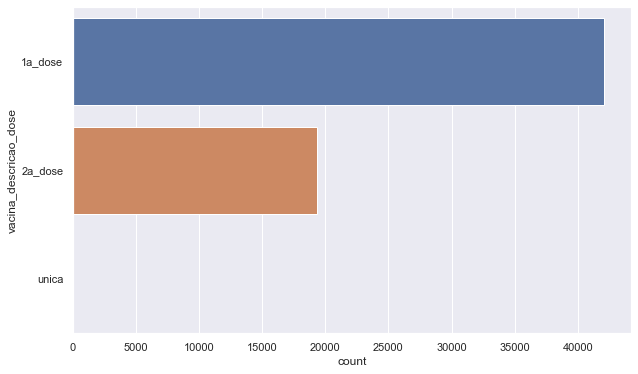

In [14]:
# Plotting das Doses tomadas:

plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# 3.1 Trabalhando com informações da '1a_dose' 
para executar o algoritmo de PREVISAO:
Neste ponto, vou definir o DataFrame df1 para '1a_dose'

In [15]:
# Agrupando as colunas da Data da Aplicacao com os vacinados da '1a_dose'

df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()

2021-05-20    1
2021-01-23    1
2021-01-29    1
2021-02-24    1
2021-03-25    1
             ..
2021-02-14    1
2021-04-20    1
2021-01-21    1
2021-01-18    1
2021-05-06    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

# 4.º Passo: 

Preparando para rodar o Algoritmo do Prophet para Previsao Séries Temporais: \
dois campos importantes 'ds' e 'y', onde:\
ds       => é a coluna DATA e já está no formato de AAAA-MM-DD\
coluna y => deve ser numérica e representa a medida que desejamos prever:

A coluna 'y' contém a soma diária das doses e separando em duas etapas as previsões: \
 y = 1.dose total da para dataframe ==> df1 \
 y = 2.dose para dataframe          ==> df2

In [16]:
# A primeira etapa será previsão da 1.dose:

df1.tail(5)

,vacina_dataAplicacao,1a_dose
124,2021-05-21,342
125,2021-05-22,231
126,2021-05-23,26
127,2021-05-24,294
128,2021-05-25,235


# Destacando Alguns Pontos Importantes: 
## 1) É necessário renomear os nomes das colunas 'ds' e'y' para rodar o Prophet

In [17]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:


df1.columns = ['ds', 'y']

In [18]:
df1.shape

(129, 2)

## 2) Este ponto é muito importante também:
## separando os dados para Treinamento (train) e para Teste

In [19]:
# Observando que a base de dados Vacina e a base de dados que iremos trablahar, Amostra,
# foram gerados dia 26/05/2021:

# Vamos assegurar que a data do AMOSTRA: Inicio 19/01/2021 e Fim: 26/5/2021


# Aqui vale uma observação sobre o Pandas, pois é ótimo para séries temporais em geral
# e tem suporte direto para períodos.

df1['ds'] = pd.DataFrame({
    'ds':  pd.date_range(start= "2021-01-19", end= "2021-05-26")
})


# Assim, conseguiremos separar as datas para Train e Teste dos dados:

data_separa = pd.to_datetime('2021-04-26')
df1_train = (df1.loc[df1['ds'] <= data_separa])
df1_teste = (df1.loc[df1['ds'] >  data_separa])


df1_train.columns =  ['ds', 'y']
df1_teste.columns =  ['ds', 'y']


print("train shape", df1_train.shape)
print("test shape",  df1_teste.shape)

train shape (98, 2)
test shape (30, 2)


In [20]:
# Definindo o intervalo do Data Base com inicio 19/01/2021 e final data 26/5/2021


df1['ds'] = pd.DataFrame({
    'ds':  pd.date_range(start= "2021-01-19", end= "2021-05-26")
})



# Assim, definindo a base de dados de Train e Teste:

end_date = pd.to_datetime('2021-04-26')

df1_train = (df1.loc[df1['ds'] <= end_date])
df1_teste = (df1.loc[df1['ds'] > end_date])


df1_train.columns =  ['ds', 'y']
df1_teste.columns =  ['ds', 'y']


print("train shape", df1_train.shape)
print("test shape",  df1_teste.shape)



train shape (98, 2)
test shape (30, 2)


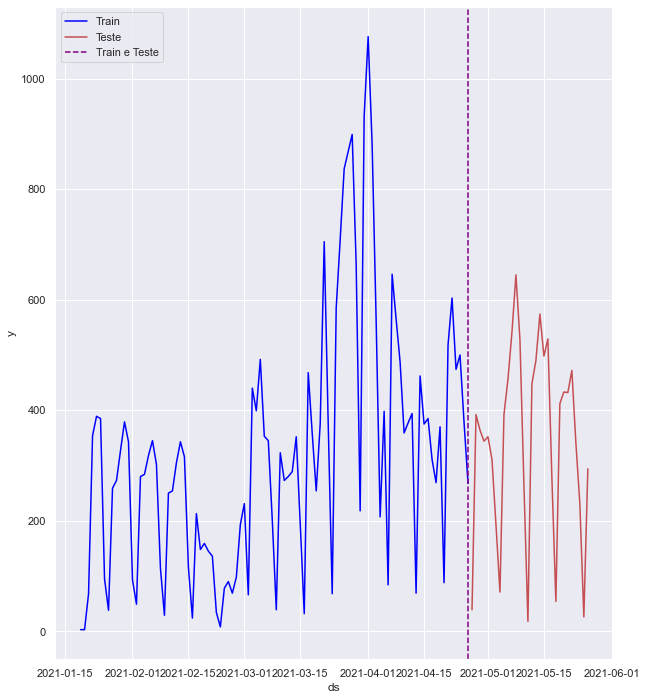

In [21]:
# Plotting Dados de Train e de Teste:

fig, ax = plt.subplots(figsize = (10,12))
sns.lineplot(x='ds', y='y', label='Train', data = df1_train, ax=ax, color = 'blue')
sns.lineplot(x='ds', y='y', label='Teste', data = df1_teste, ax=ax, color = 'r')
ax.axvline(end_date, color = 'purple', linestyle='--', label='Train e Teste')
ax.legend(loc='upper left')


# 5.º Passo: 
## Executando o Modelo de Prophet() - Primeiro Modelo, model1:

Executando o primeiro modelo do algoritmo Prophet(), sem fornecer nenhum parâmetros:

In [22]:
# Vamos treinar o Modelo1 com os dados de Train no Modelo Prophet

model1 = Prophet(interval_width = 0.95) # por padrao é 0.80%

# Faremos o treinamento o meodelo:

model1.fit(df1_train)

# O Prophet disponibiliza um dataframe adequado que se estenda para o futuro 
# por um número especificado de dias (que escolhemos para prever) 
# usando o método auxiliar `make_future_dataframe.


 # Importante: aqui o periodo tem que ser do do tamanho do DataFrame de teste e frequencia Diaria:
    
future1   = model1.make_future_dataframe(periods = df1_teste.shape[0], freq = 'd')


# O método PREDICT, atribuirá cada linha em future um valor previsto que ele nomeia "yhat". 
# Se você passar datas históricas, isso fornecerá um ajuste na amostra. 
# O objeto FORECAST é um novo dataframe que inclui uma coluna yhatcom a previsão, 
# bem como colunas para componentes e intervalos de incerteza.

forecast1 = model1.predict(future1)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# O forecast é o nosso DataFrame de previsão, as colunas mais importantes são:
# ds, yhat, yhat_lower e yhat_upper, onde:

# yhat = previsão prevista
# yhat_lower = limite inferior das nossas previsões
# yhat_upper = limite superior

# OBS:  yhat_lower e yhat_upper: são as componentes do intervalo de incertezas,
# quanto mais distante o tempo à frente, mais incerto fica a previsão.

forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
123,2021-05-22,640.884126,318.531947,982.082122
124,2021-05-23,633.016703,298.947540,958.471339
125,2021-05-24,514.311045,214.662515,844.874102
126,2021-05-25,343.734263,26.579137,677.545298
127,2021-05-26,675.674636,376.792244,1009.197810


# 6.º Passo:
# Fazendo os gráficos com as previsões obtidas para cada modelo:


Teremos alguns modelos testados e faremos uso do utilitário performance_metrics:\
1) para calcular o erro quadrático médio (MSE), \
2) erro quadrático médio (RMSE), \
3) erro absoluto médio (MAE), \
4) erro percentual médio absoluto (MAPE)\

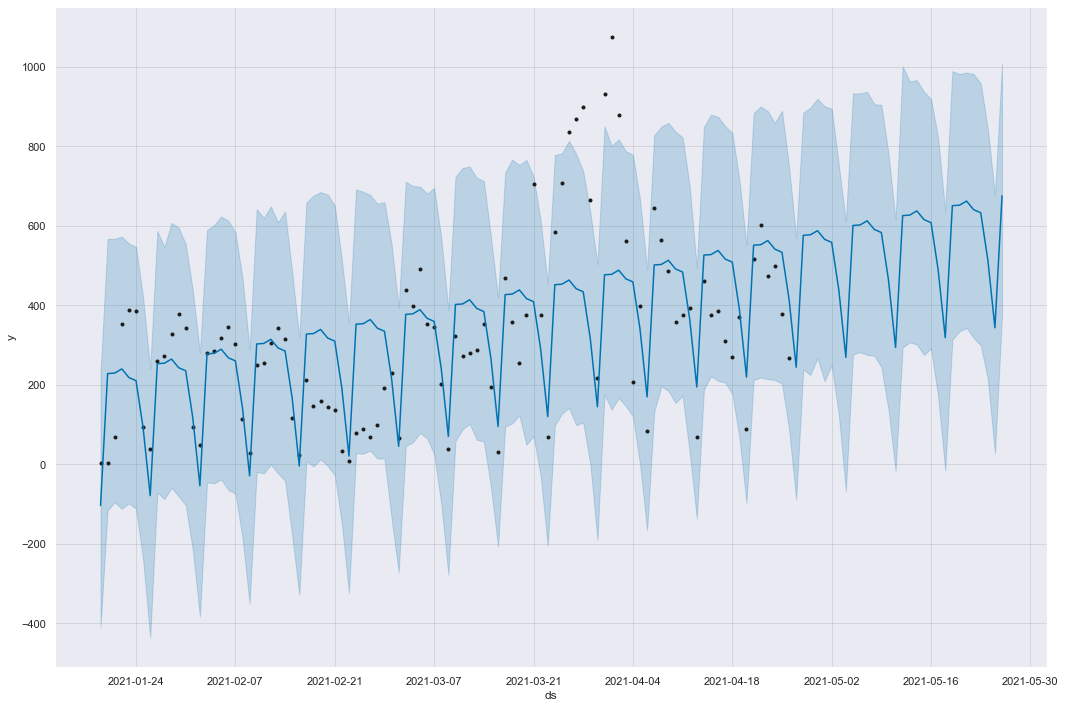

In [29]:
# Plotting: Traçando as Previsôes, primeiro  modelo testado, sem parâmetros:

# fig1 = model1.plot(forecast1)

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig = model1.plot(forecast1,ax=ax)
plt.show()


In [25]:
# Comentando sobre o grafico da fig1, acima:

# Sobre o gráfico acima, os pontos pretos são o total de vacinados. 
# O tom azul representa o intervalo de confiança de 80% em torno da previsão, por padrão, onde o
# modelo tenta ajustar todos os pontos de dados suavemente.
#

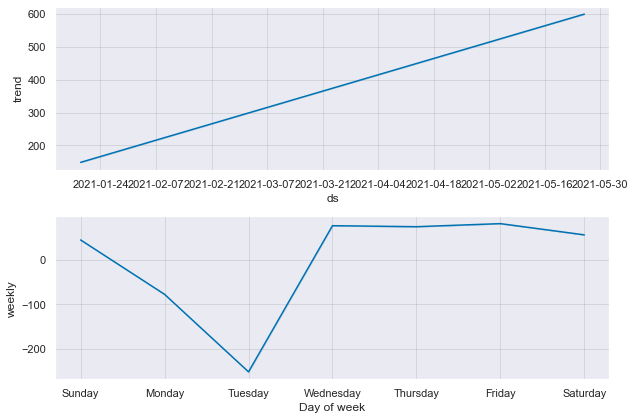

In [26]:
# Plotting os componentes da Previsão:

fig2 = model1.plot_components(forecast1)

<AxesSubplot:title={'center':'Data Atual x Previsão'}, xlabel='ds'>

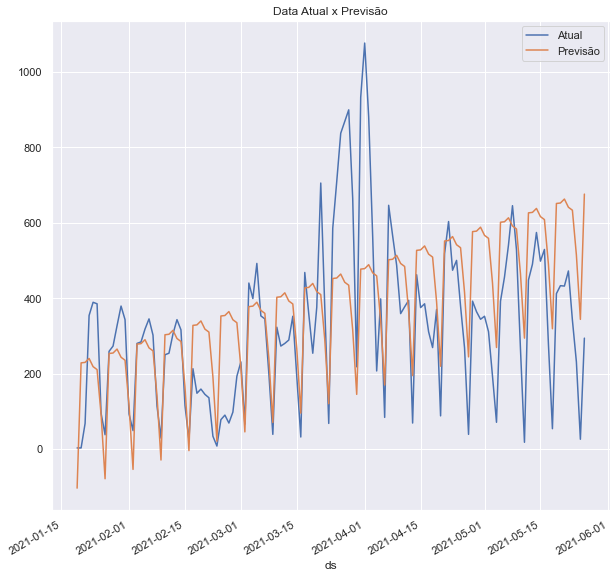

In [27]:
# Plotting os valores: Atual ('y') e a Previsão obtidos do Forecast{'yhat'}:

ax = (df1.plot(x = 'ds', y = 'y',  figsize =(12,8), label='Atual', title = "Data Atual x Previsão"))
forecast1.plot( x = 'ds', y ='yhat',figsize =(10,10), label ='Previsão' ,title = "Data Atual x Previsão", ax =ax )

# 7.º Passo:
 
## Função Cross-Validation do primeiro modelo, nem nenhuma alteração dos pariametros:

Esse procedimento de validação cruzada pode ser feito automaticamente para uma faixa de cortes históricos usando a função cross_validation. 

Especificamos:
1) o horizonte de previsão (horizon) \
2) opcionalmente, o tamanho do período de treinamento inicial ( initial) \
3) o espaçamento entre as datas de corte ( period), o período de treinamento inicial \
é definido como três vezes o horizonte e os cortes são feitos a cada meio horizonte.\

# Entendendo a saída do resultado Cross_Validation:
A saída de cross_validation é um dataframe com os valores reais 'y' 
e os valores de previsão fora da amostra 'yhat', em cada data de previsão simulada e para cada data de corte.
Em particular, uma previsão é feita para cada ponto observado entre cutoffe cutoff + horizon. Esses dados podem então ser usados para medidas de erro de computação de 'yhat' e 'y'.

Aqui, fazemos validação cruzada para avaliar:
1) desempenho da previsão em um horizonte de 10 dias, \
2) começando com 50 dias de dados de treinamento no primeiro corte \
3) fazendo previsões a cada 30 dias.

In [41]:
# Utilizando a Função Cross-Validation

df_cross1 = cross_validation(model1, initial = '50 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 2 forecasts with cutoffs between 2021-03-17 00:00:00 and 2021-03-27 00:00:00


# Vericando as Métricas:

O performance_metrics utilitário pode ser usado para calcular algumas estatísticas úteis \
do desempenho da previsão ( yhat, yhat_lowere yhat_upper comparado a y), \
como uma função da distância do corte (quão longe no futuro estava a previsão). 

1) As estatísticas calculadas são erro quadrático médio (MSE), \
2) erro quadrático médio médio (RMSE), \
3) erro absoluto médio (MAE), \
4) erro percentual absoluto médio (MAPE), \
5) erro percentual absoluto médio (MDAPE) e\
6) cobertura das estimativas yhat_lowere yhat_upper. 

OBS: As métricas são calculados em uma janela contínua das previsões df_cross,
após a classificação por horizonte ( dsmenos cutoff). Por padrão, 
10% das previsões serão incluídas em cada janela, 
mas isso pode ser alterado com o rolling_window argumento.

In [42]:
# Calculando as métricas para Cross Validation do Modelo1:

df_perform1 = performance_metrics(df_cross1)

df_perform1.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,55338.000138,235.240303,174.156146,0.310544,0.271765,0.377371,0.666667
1,4 days,88308.518411,297.167492,231.758855,0.361446,0.390750,0.460600,0.500000
2,5 days,141229.508568,375.805147,302.054127,0.420323,0.533215,0.567771,0.333333
3,6 days,166159.611757,407.626805,353.285328,0.451664,0.533215,0.616524,0.166667
4,7 days,116668.128022,341.567165,266.348872,0.374381,0.474422,0.503724,0.333333


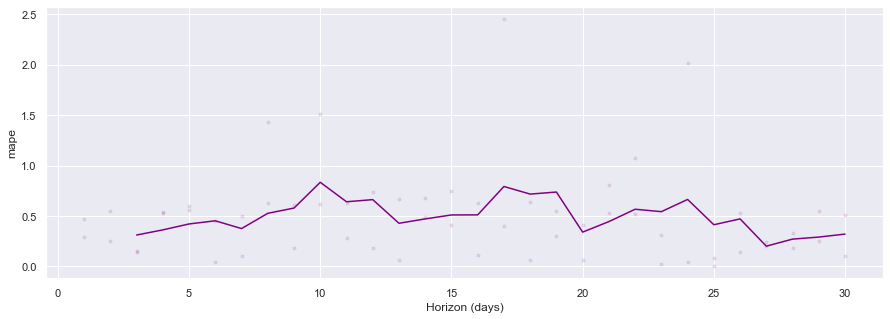

In [43]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross1, metric='mape', color = 'purple', figsize = (10,30), ax=ax)

plt.show()


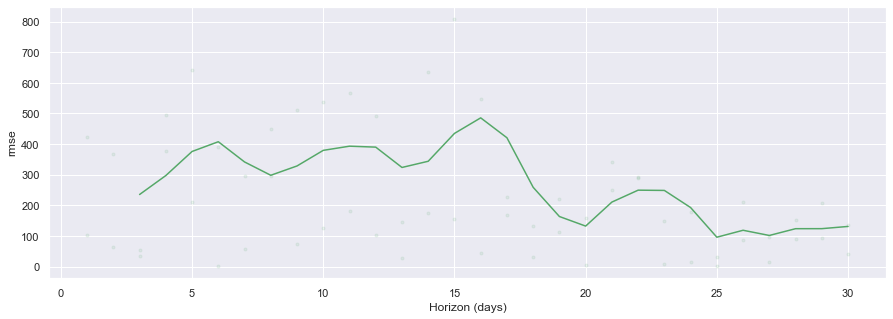

In [44]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross1, metric='rmse', color = 'g', figsize = (10,30), ax=ax)

plt.show()

# 8.º Passo:

## Segundo Modelo - Model2:

Ajustando Parâmetros para melhorar a previsão:\
Fazendo os ajustes no parâmetros do modelo do Prophet para que os valores das previsões\
sejam positivos:\

Note que o nome do modelo será model1 com os parâmetros do Prophet serão ajustados:

1) 'interval_width = 0.95' para definir o intervalo de incerteza, para produzir um \
intervalo de confiança em torno da previsão;\
2) alterando os valores de sazonalidade: diaria,semanal, mensal e anual;\
3) mudando o valor de changepoint_prior = 2\


In [45]:
# Gerando segundo modelo, model2 com os parâmetros:

model2 = Prophet(interval_width = 0.95, # por padrão é 0.80%
               changepoint_prior_scale = 2,
               daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)

# Treinado o Modelo2 com dados de Train cujo periodo será o tamanho df1.teste

    
model2.fit(df1_train)

future2   = model2.make_future_dataframe(periods = df1_teste.shape[0], freq = 'd')

forecast2 = model2.predict(future2)


In [46]:
end_date = pd.to_datetime('2021-04-26')


print("train shape", df1_train.shape)
print("test shape",  df1_teste.shape)


forecast_train = (forecast2.loc[forecast2['ds'] <= end_date])
forecast_teste = (forecast2.loc[forecast2['ds'] > end_date])

print("Forecast Train shape", forecast_train.shape)
print("Forecast Teste shape",  forecast_teste.shape)

#previsao = forecast4['ds'] <= end_date

#forecast_train = forecast4[previsao]
#forecast_teste = forecast4[~ previsao]

train shape (98, 2)
test shape (30, 2)
Forecast Train shape (98, 28)
Forecast Teste shape (30, 28)


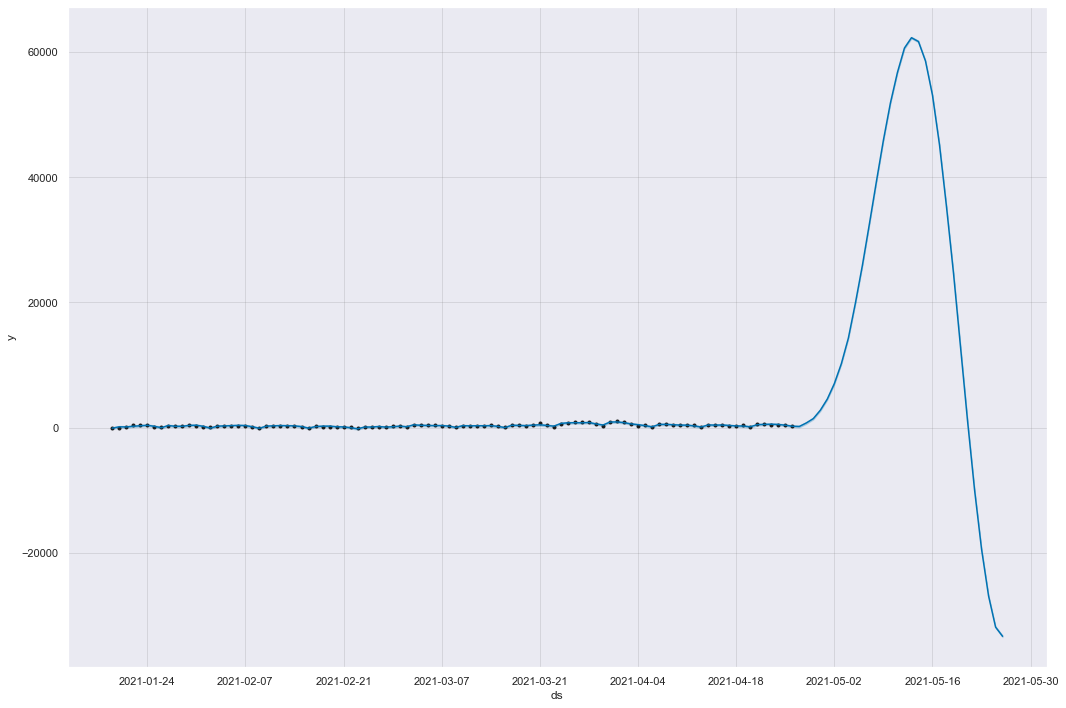

In [47]:
# Plotting: Traçando as Previsôes para model2:

# fig5 = model2.plot(forecast2)

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig4 = model2.plot(forecast2,ax=ax)
plt.show()


In [49]:
# Utilizando a Função Cross-Validation

df_cross2 = cross_validation(model2, initial = '50 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 2 forecasts with cutoffs between 2021-03-17 00:00:00 and 2021-03-27 00:00:00


In [50]:
# Verificando as Métricas do Modelo2:

df_perform2 = performance_metrics(df_cross2)
df_perform2.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.129577e+06,1062.815534,796.808185,2.649920,1.443375,0.837099,0.0
1,4 days,2.707966e+06,1645.589750,1301.126706,3.167441,1.575956,1.009345,0.0
2,5 days,5.998904e+06,2449.266103,2022.316210,3.930045,3.480215,1.154774,0.0
3,6 days,1.293985e+07,3597.200847,3046.428982,9.491470,3.863768,1.316138,0.0
4,7 days,2.614766e+07,5113.478364,4486.870951,12.402115,6.585286,1.561574,0.0


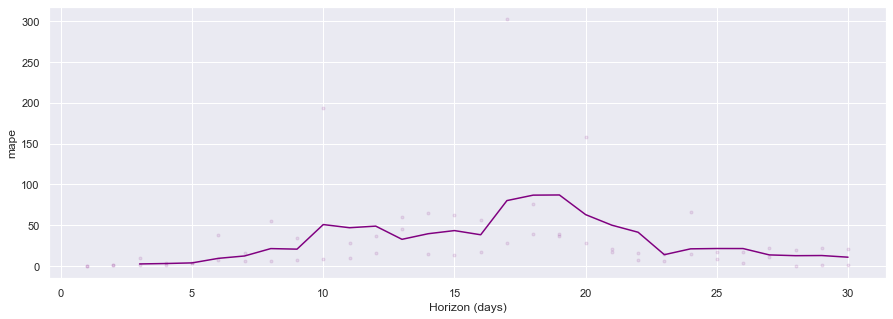

In [51]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do segundo modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross2, metric='mape', color = 'purple', figsize = (10,30), ax=ax)

plt.show()


In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross2, metric='rmse', color = 'g', figsize = (10,30), ax=ax)

plt.show()

# # 9.º Passo:

# Testando um novo modelo, model3:

## Aqui o ajuste principal que fará a diferença dos modelos anteriores será 
a definição do parâmetro "grown = logistic", crescimento logístico:\
O objetivo será que a previsão ficar positiva: \
2) Alterando o parâmetro do grown = 'logistic', torna-se necessário mudar\
- o limite (valor máximo que seus dados alcançarão)  \
- o piso (valor mínimo que seus dados alcançarão)\
3) changepoint_range

OBS: O limite máximo da população vacinada é de 211.755.692 de brasileiros, \
pois muito provavelmente não atingirá esse limite dentro do tempo que está prevendo. \
Vou definir algo mais razoável, como 500.000, e deixar o limite aumentar lentamente com o tempo.

4) changepoint_prior_scale: é provavelmente o parâmetro de maior impacto, o argumento \
de entrada changepoint_prior_scale, por padrão, este parâmetro é definido como 0,05, \
aumentar tornará a tendência mais flexível.\

OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
valores Mínimo e Máximo

Foi definido o parâmetro Future['cap'] = 500.000 corresponderá ao número máximo de
brasileiros vacinados.


In [52]:
# Fazendo o terceiro modelo, model3 com alteração de outros parâemtros:


df1_train['floor'] = 1      # valor do piso
df1_train['cap']   = 3000   # valor do teto (total vacinados por dia)


model3 = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2)

# Calculando treinamento:
model3.fit(df1_train)

# Fazendo a previsão:

future3 = model3.make_future_dataframe(periods = df1_teste.shape[0], freq = 'd')


future3['cap']   =   3000                # Representa Populacao Brasileira = 211755692  
future3['floor'] = 1

forecast3 = model3.predict(future3)


<ipython-input-52-47cb5ba504b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['floor'] = 1      # valor do piso
<ipython-input-52-47cb5ba504b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['cap']   = 3000   # valor do teto (total vacinados por dia)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


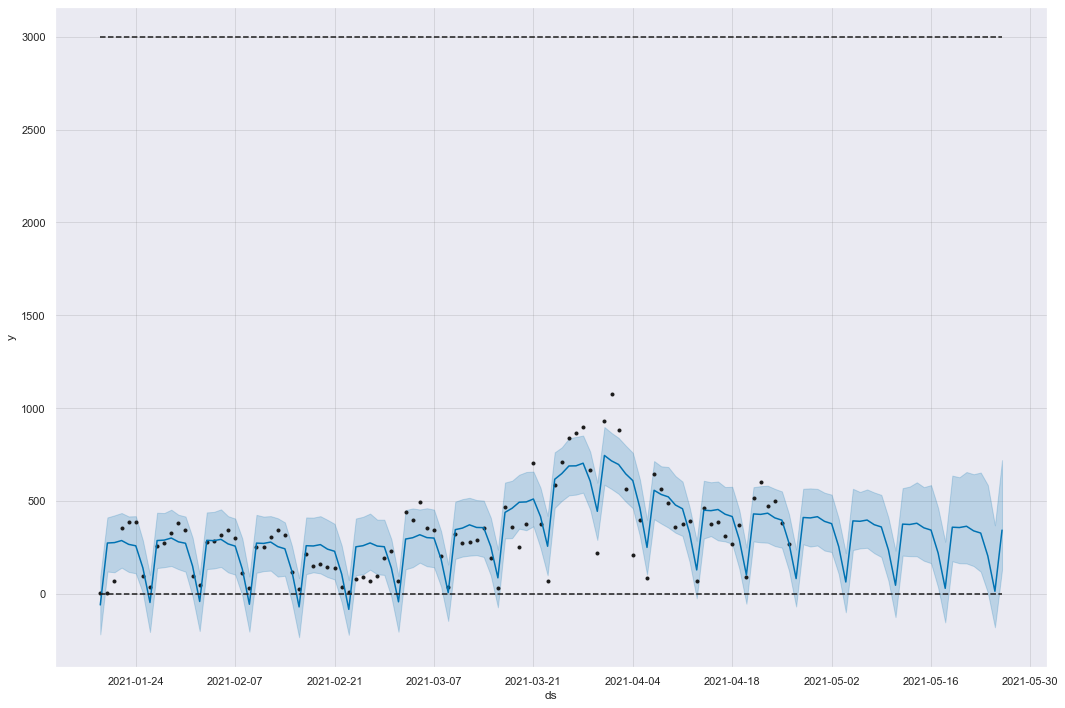

In [53]:
# Plotting  forecast modelo3:

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig6 = model3.plot(forecast3,ax=ax)
plt.show()


In [55]:
# Utilizando a Função Cross-Validation para Modelo 3:

df_cross3 = cross_validation(model3, initial = '50 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 2 forecasts with cutoffs between 2021-03-17 00:00:00 and 2021-03-27 00:00:00


In [56]:
df_cross3.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-18,303.970131,212.568770,400.464894,358,2021-03-17
1,2021-03-19,368.808682,277.140656,461.185011,254,2021-03-17
2,2021-03-20,373.628542,281.246992,472.801945,376,2021-03-17
3,2021-03-21,377.885413,285.794271,473.774326,705,2021-03-17
4,2021-03-22,216.196115,114.246706,319.697655,376,2021-03-17


In [57]:
# Vericando as Metricas, model3:

df_perform3 = performance_metrics(df_cross3)
df_perform3.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,58760.693630,242.406051,153.611832,0.573567,0.194845,0.318589,0.500000
1,4 days,80806.259692,284.264419,221.868947,0.649918,0.345386,0.413786,0.166667
2,5 days,80342.628061,283.447752,219.609146,0.621112,0.304520,0.421539,0.333333
3,6 days,59725.162814,244.387321,206.289689,0.399431,0.444501,0.389152,0.333333
4,7 days,164976.200527,406.172624,303.941040,0.609787,0.456121,0.490116,0.333333


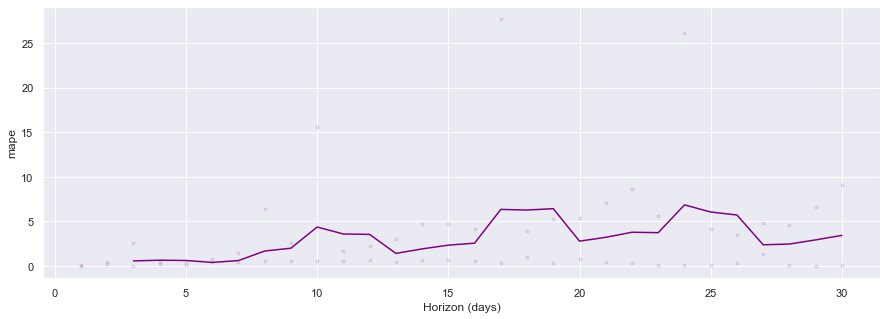

In [58]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross3, metric='mape', color = 'purple', figsize = (10,30), ax=ax)

plt.show()


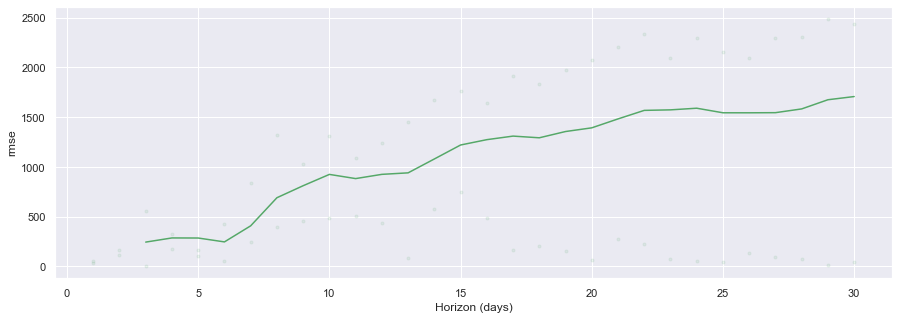

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross3, metric='rmse', color = 'g', figsize = (10,30), ax=ax)

plt.show()

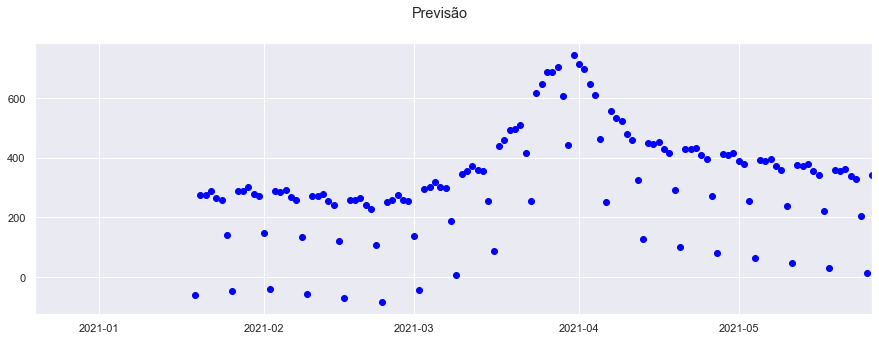

In [62]:
# Plotting Forecast:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Inicio da Vacinação no Brasil 18/12/2020

#ax.scatter(df1['ds'], df1['y'], color='red', label="Atual")
ax.scatter(forecast3['ds'], forecast3['yhat'], color='blue',label= 'Previsao')

# Plotting o atual e os valores obtidos do Forecast:

ax.set_xbound(lower ='2020-12-20', upper ='2021-05-26')
# ax.set_ylim(0, 1000)
plot = plt.suptitle('Previsão')

<AxesSubplot:title={'center':'DADOS ATUAIS X FUTURO'}, xlabel='ds'>

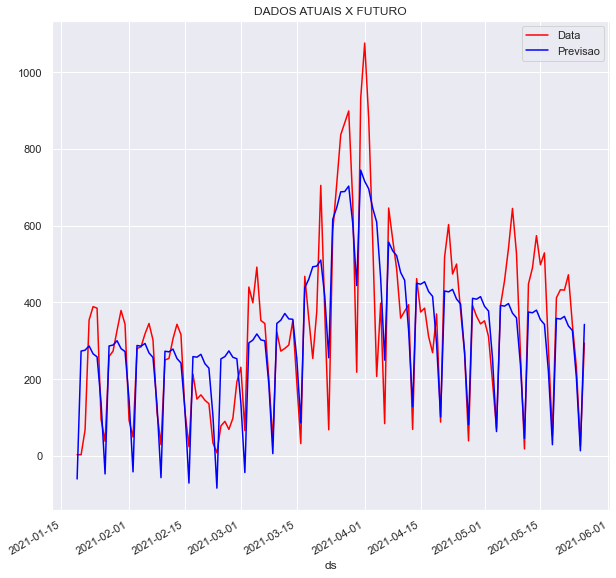

In [92]:
# Plotting comparando valores: Atual x Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast3.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='DADOS ATUAIS X FUTURO', color ='blue',ax=ax)

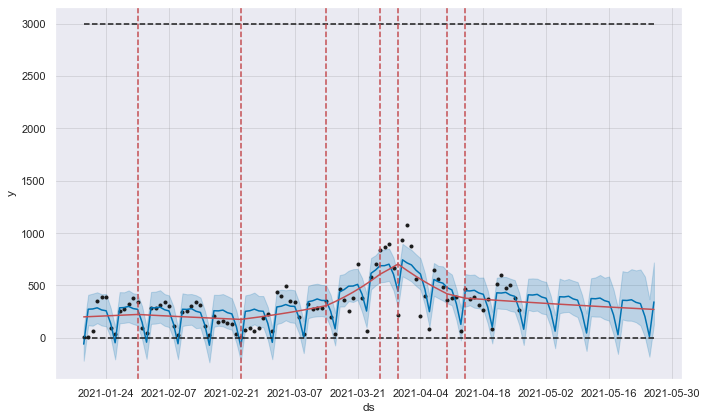

In [64]:
# Plotting dados Atual x Futuro

fig = model3.plot(forecast3)
a   = add_changepoints_to_plot(fig.gca(), model3, forecast3)

# 10.º Passo:
# Testando o quarto modelo, model4 com os feriados:
Adicionando os feriados deste ano de 2021/2022 do calendário do Brasil:

In [65]:
# Adicionando os Feriados do Brasil para melhorar a acurária da Previsão da Serie Temporal:

import holidays
    
feriado = holidays.Brazil()

# Feriados no Brasil:
for feriado in feriado['2021-01-01': '2022-12-31'] :
    print(feriado)

2021-01-01
2021-02-16
2021-02-17
2021-04-02
2021-04-04
2021-04-21
2021-05-01
2021-06-03
2021-09-07
2021-10-12
2021-11-02
2021-11-15
2021-12-25
2022-01-01
2022-03-01
2022-03-02
2022-04-15
2022-04-17
2022-04-21
2022-05-01
2022-06-16
2022-09-07
2022-10-12
2022-11-02
2022-11-15
2022-12-25


In [66]:
# Definindo os feriados do calendário do Brasil:

playoffs = pd.DataFrame ({
  'holiday': 'playoff', 
  'ds': pd.to_datetime (['2021-01-01', '2021-02-16', '2021-02-17', '2021-04-02', '2021-04-04', 
                          '2021-04-21', '2021-05-01', '2021-06-03', '2021-09-07', '2021-10-12',
                          '2021-11-02', '2021-11-15', '2021-12-25',
                          '2022-01-01', '2022-03-01', '2022-03-02', '2022-04-15', '2022-04-17',
                          '2022-04-21', '2022-05-01', '2022-06-16', '2022-09-07', '2022-10-12',
                          '2022-11-02', '2022-11-15', '2022-12-25'
                        
                        ]), 
  ' lower_window ': 0, 
  ' upper_window ': 1, 
})

others = pd.DataFrame({  
  'holiday': 'others',
  'ds': pd.to_datetime(['2021-07-09', '2021-11-20']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, others))

# 12.º Informando os feriados do calendário e rodando novamente o Prophet
para verificar se houve melhoria da previsao

In [67]:
df1_train['cap']  = 3000   # media vacinados por dia
df1_train['floor'] = 1      # valor do piso

model4 = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2, holidays=holidays)

# Calculando treinamento:
model4.fit(df1_train)

# Fazendo a previsão:

future4 = model4.make_future_dataframe(periods = df1_teste.shape[0], freq = 'd')



future4['cap']   = 3000                # Representa Populacao Brasileira = 211755692  

future4['floor'] = 1

forecast4 = model4.predict(future4)


<ipython-input-67-22f24b503a7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['cap']  = 3000   # media vacinados por dia
<ipython-input-67-22f24b503a7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['floor'] = 1      # valor do piso
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


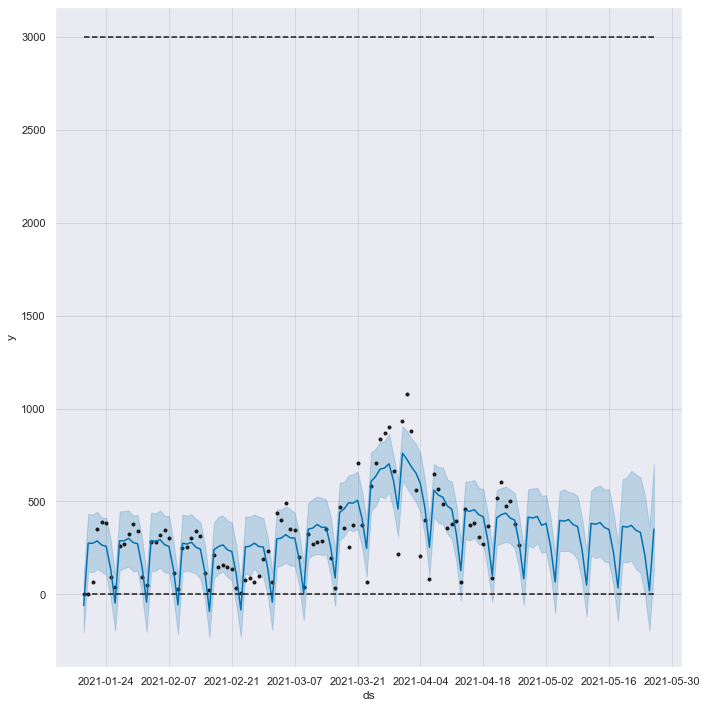

In [87]:
# Plotting o forecast do quarto modelo, model4:

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(10)
fig8 = model4.plot(forecast4, ax=ax)
plt.show()

In [69]:
end_date = pd.to_datetime('2021-04-26')


print("train shape", df1_train.shape)
print("test shape",  df1_teste.shape)


forecast_train = (forecast4.loc[forecast4['ds'] <= end_date])
forecast_teste = (forecast4.loc[forecast4['ds'] > end_date])

print("Forecast Train shape", forecast_train.shape)
print("Forecast Teste shape",  forecast_teste.shape)

#previsao = forecast4['ds'] <= end_date

#forecast_train = forecast4[previsao]
#forecast_teste = forecast4[~ previsao]

train shape (98, 4)
test shape (30, 2)
Forecast Train shape (98, 27)
Forecast Teste shape (30, 27)


In [71]:
# Recalculando a Função Croos-Validation do modelo 4:

df_cross4 = cross_validation(model4, initial='50 days', period='10 days', horizon = '30 days')

df_cross4.head()
df_perform4 = performance_metrics(df_cross4)
df_perform4.head()



INFO:prophet:Making 2 forecasts with cutoffs between 2021-03-17 00:00:00 and 2021-03-27 00:00:00


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,58235.010977,241.319313,153.184510,0.571473,0.193044,0.318079,0.500000
1,4 days,80240.507740,283.267555,221.311483,0.648119,0.345592,0.413913,0.166667
2,5 days,79793.322347,282.477118,219.076980,0.619482,0.303850,0.422040,0.333333
3,6 days,63450.083605,251.893000,209.775944,0.396043,0.446042,0.388193,0.333333
4,7 days,168732.008698,410.770019,308.107245,0.607289,0.471734,0.490549,0.333333


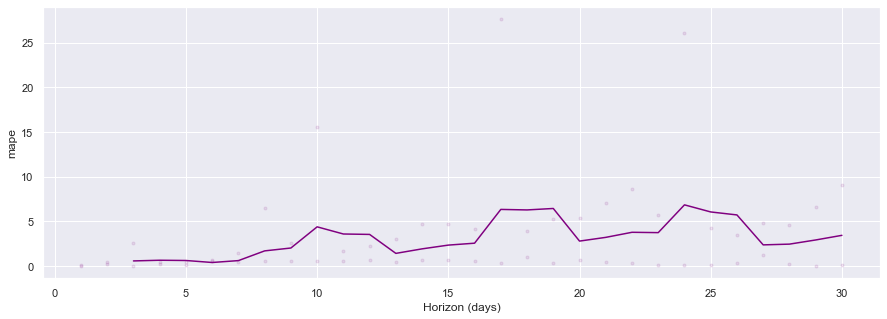

In [73]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mape', color = 'purple', figsize = (10,30), ax=ax)

plt.show()


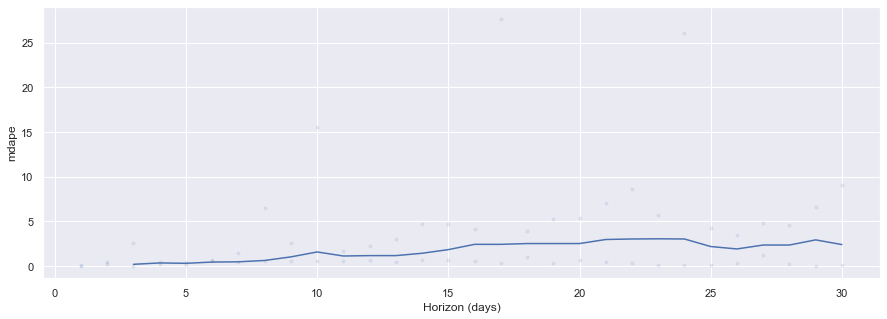

In [74]:
# Plotting o MAPE obtido da Funcao: Cross-Validation, do primeiro modelo:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mdape', figsize = (10,30), ax=ax)

plt.show()


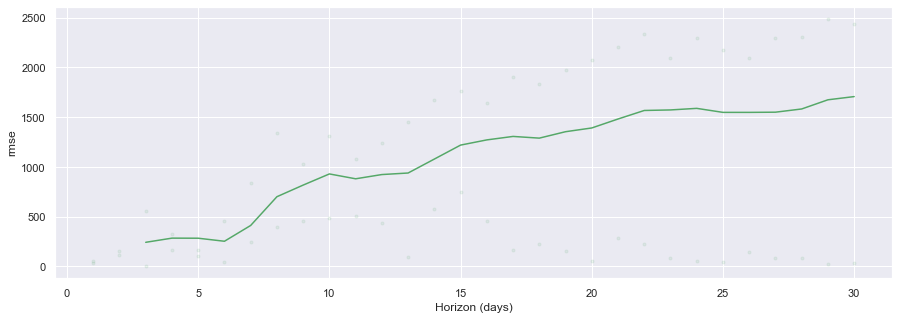

In [75]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='rmse', color = 'g', figsize = (10,30), ax=ax)

plt.show()


# 12.º Passo:

Vamos dividir as previsões em treinamento e conjunto de teste, usando o Forecast do
último modelo, modelo4:


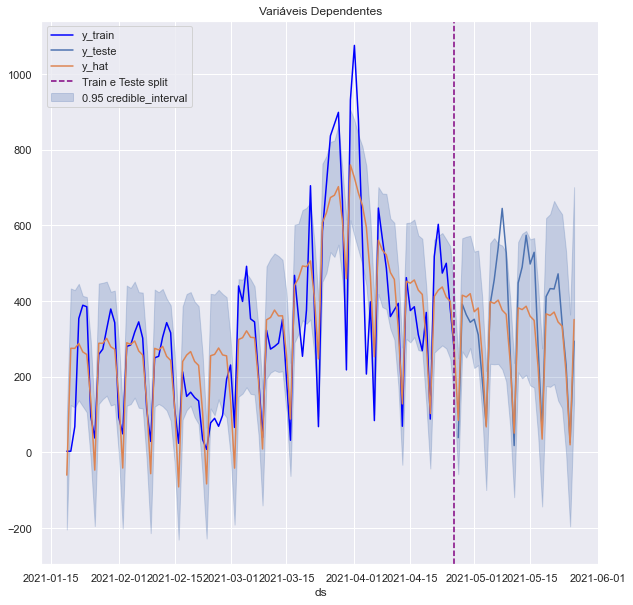

In [81]:
fig, ax = plt.subplots(figsize=(10,10))

ax.fill_between(
    x =forecast4['ds'],
    y1=forecast4['yhat_lower'],
    y2=forecast4['yhat_upper'],
    color = 'b', 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y',    label ='y_train', color = 'blue', data  = df1_train, ax=ax)
sns.lineplot(x='ds', y='y',    label ='y_teste', data   = df1_teste, ax=ax)
sns.lineplot(x='ds', y='yhat', label ='y_hat', data     = forecast4, ax=ax)
ax.axvline(end_date, color = 'purple', linestyle='--', label='Train e Teste split')
ax.legend(loc='upper left')
ax.set(title='Variáveis Dependentes', ylabel='');

[Text(0.5, 1.0, 'Dados Teste x Previsões')]

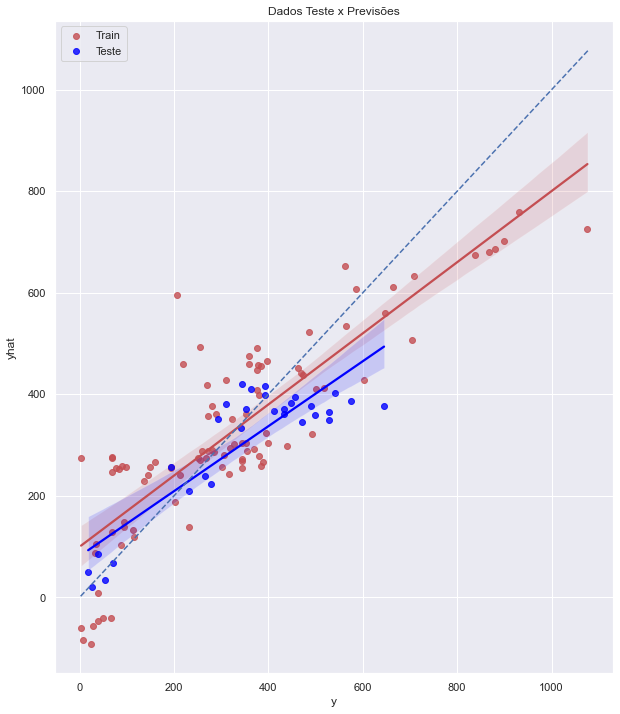

In [84]:
fig, ax = plt.subplots(figsize=(10,12))

# Generate diagonal line to plot. 
d_x = np.linspace(start = df1_train['y'].min() - 1, stop= df1_train['y'].max() + 1, num=100)

sns.regplot(x= df1_train['y'], y= forecast_train['yhat'], color= 'r', label='Train', ax=ax)
sns.regplot(x= df1_teste['y'], y= forecast_teste['yhat'], color= 'blue', label='Teste', ax=ax)
sns.lineplot(x= d_x, y = d_x, dashes={'linestyle': ''}, color= 'b', ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Dados Teste x Previsões')


# Vamos calcular o r2_score e mean_absolute_error 
## no conjunto de treinamento e teste:

In [85]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true = df1_train['y'],
                                     y_pred = forecast_train['yhat'])))

print('r2 teste: {}'.format(r2_score(y_true= df1_teste['y'], 
                                     y_pred= forecast_teste['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true= df1_train['y'], 
                                                 y_pred= forecast_train['yhat'])))

print('mae teste: {}'.format(mean_absolute_error(y_true= df1_teste['y'], 
                                                 y_pred= forecast_teste['yhat'])))


r2 train: 0.7293505779662084
r2 teste: 0.6759486720020877
------------------------------
mae train: 93.66570968540104
mae teste: 73.41954288976531


/Users/nubiapiccirilli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nubiapiccirilli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/nubiapiccirilli/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be remov

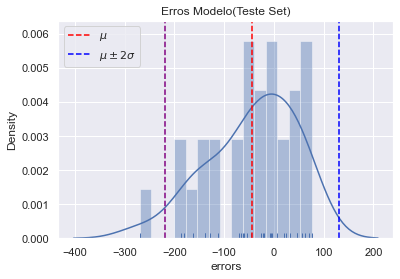

In [86]:
forecast_teste.loc[:, 'errors'] = forecast_teste.loc[:, 'yhat'] - df1_teste.loc[:, 'y']

errors_mean = forecast_teste['errors'].mean()
errors_std  = forecast_teste['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=forecast_teste['errors'], ax=ax, bins= 15, rug=True) # distplot
ax.axvline(x=errors_mean, color= 'red', linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color= 'blue', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color= 'purple', linestyle='--')
ax.legend()
ax.set(title='Erros Modelo(Teste Set)');


# Finalizamos com a análise da vacina '1. Dose'
## Conclusão:

A melhor performance obtida pelo algoritmo Prophet, Séries Temporais, a previsão foi
melhor no terceiro modelo, quando foi definido o parâmetro growth = logistic com os valores dos piso e teto. 

No quarto modelo, model4, foram treinados com os mesmos paarámetros do terceiro modelo, 
a diferença é que foi acrescentado os feriados do Brasil para melhorar a previsão do algoritmo.


# 13.º Passo:
Neste ponto estarei fazendo as Previsões da Segunda Dose da Vacina:
Praticamente são os mesmos procedimentos da 1. Dose da vacina

In [ ]:
df2 = df
df2.shape

In [ ]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()

In [ ]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [ ]:
df2

In [ ]:
# Plotting Data Atual

df2.plot(x ='ds', y ='y', figsize = (10,8), title = 'Datas Vacinação da 2. Dose' , color = 'purple')

# Aqui farei o modelo Prophet com os parâmetros do quarto modelo da 1.dose, pois os testes são semelhantes.

In [ ]:
df2['cap']  = 7000   # media vacinados por dia
df2['floor'] = 1      # valor do piso

# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

modelS = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 2, holidays=holidays)

# Calculando treinamento:
modelS.fit(df2)

# Fazendo a previsão:

futureS = modelS.make_future_dataframe(periods = 365)


futureS['cap']   = 500000                # Representa Populacao Brasileira = 211755692  
futureS['floor'] = 1

forecastS = modelS.predict(future4)

In [ ]:
# Função Croos-Validation para modelo S da Segunda Dose da Vacina:

df_crossS = cross_validation(modelS, initial='365 days', period='10 days', horizon = '30 days')

df_crossS.head()
df_performS = performance_metrics(df_crossS)
df_performS.head()


In [ ]:
# Plotting Median Absolute Percentage Error: MDAPE
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_crossS, metric='mdape', figsize = (10,30), ax=ax)

plt.show()


In [ ]:
# Plotting resultados da Segunda Dose da Vacina, com MAPE

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='mape', figsize = (10,30), ax=ax)

plt.show()



In [ ]:
# Plotting Median Absolute Percentage Error: RMSE

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = plot_cross_validation_metric(df_cross4, metric='rmse', figsize = (10,30), ax=ax)

plt.show()
